# Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

# Hypothesis
#### Store Properties
1. Location of the store
2. Size of the store
3. Competition prices
4. Distance from stores with similar products
5. City vs Rural
6. Population of the Area
7. Amount of customers for every month
8. Money spent on marketing
9. Ambience of the store
10. Employee retention rate

#### Product Properties
1. Historic popularity of products on certain months (Seasonality)
2. Amount of money spent advertising product
3. Utility of item ( how useful is the item)
4. Packaging of the item 
5. Location of item inside of the store
6. Amount of other stores with the same item
7. Generic or name brand product
8. Promotions/Coupons
9. Amount of time the item has been in stock (Maybe newer items are less likely to sell because people don't recognize it)
10. Controversies surrounding a product (Has the item been involved in any news articles that would increase/decrease the price. Ex. Blue Bell ice cream licker)
11. Sentiment Analysis on Product on Social Media 
12. Social Media presence of product

While some of these may not be available to us, or would be hard to measure, it's a good idea to think about how to tackle before even looking at the data to get a better understanding of the problem.

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
import impyute
%matplotlib inline

In [367]:
df = pd.read_csv('Train.txt')

# Data Exploration

In [368]:
df.shape

(8523, 12)

In [369]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


From looking at the head of the data, we can determine that some of the columns are categorical, others are float, and some are int. Also, the data has some missing values which we will explore next.

In [370]:
df.apply(lambda col: sum(col.isnull()))

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

That's quite a large amount of null values. However, it's limited to only those 2 columns. Maybe if the column isn't important we might just consider dropping the column, but of course we will explore our options later.

In [371]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Observations
**Item_Visibility**: The minimum value is 0. This makes no sense, this would mean the product is not being displayed at all.<br> 
**Outlet_Establishment_Year**: The oldest store is from 1985, and the newest is is 2009. We can use this information to calculate the age of the store and this may be a better predictor of sales.<br>
**Item_Outlet_Sales**: Might be right-skewed just by looking at the mean and median. Very large IQR, we can explore the variability later using a boxplot.<br>

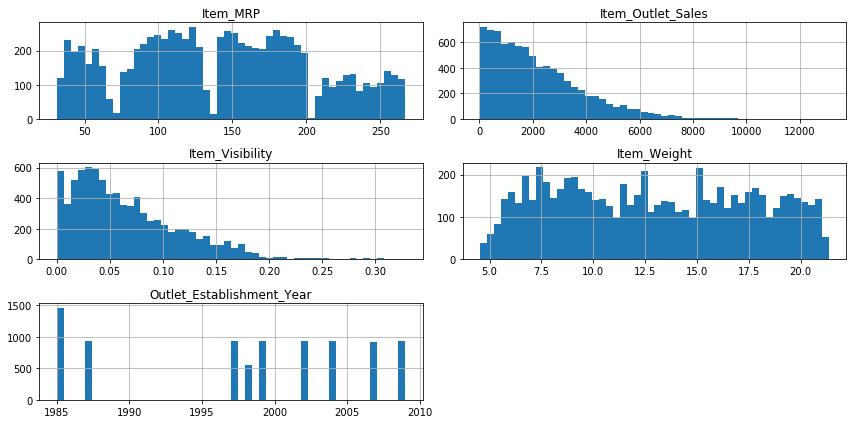

In [372]:
df.hist(bins=50, figsize=(12,6))
plt.tight_layout()
plt.show()

### Observations
**Item_MRP**: Looking at the shape of the graph it appears that these values can be bucketed into different ranges.<br>
**Item_Outlet_Sales**: The graph shows that this is indeed right skewed, with one outlier all the way at the very end (about 13k).<br>

**Item_Visibility**: Also right skewed, but not as heavily. We can also note that there are a fair amount of products with a visibility of 0 or close to 0.<br>

**Outlet_Establishment_Year**: Theres a period of about 10 years in which no new stores were built. 

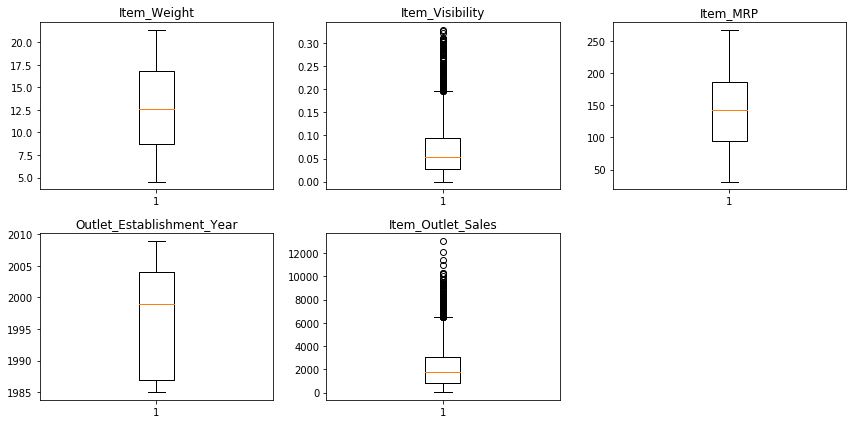

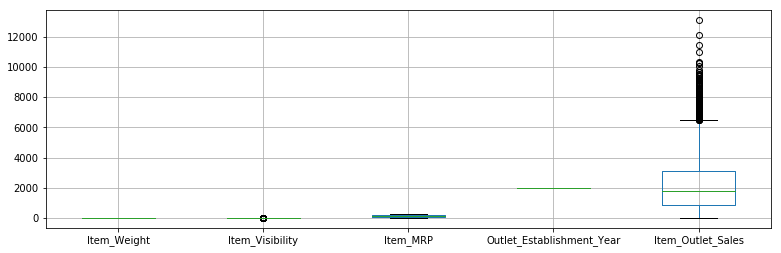

In [373]:
fig, axes = plt.subplots(2,3, figsize=(12,6))
i = 0

for column in df.select_dtypes(include=np.number):
    axes[(i // 3), (i % 3)].boxplot(df[column].dropna())
    axes[(i // 3), (i % 3)].set_title(column)
    i += 1
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()

plt.figure(figsize=(13,4))
df.boxplot()
plt.show()

#### Observations
- **Item_Visibility** and **Item_Outlet_Sales** have several points that are labeled as outliers (proving again that we have skewed data).
- High variability in the **Outlet_Establishment_Year**
- The numeric variables are all on vastly different scales, so we will have to *normalize* some of these variables.

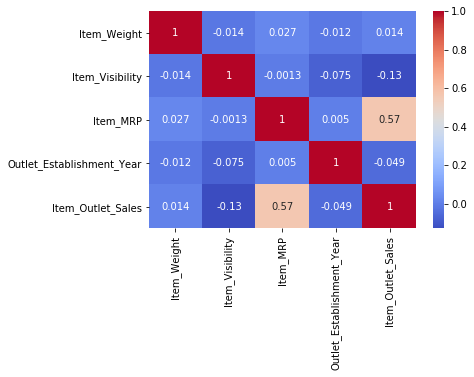

In [374]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

Text(0.5, 1.0, 'Item MRP v Item Outlet Sales')

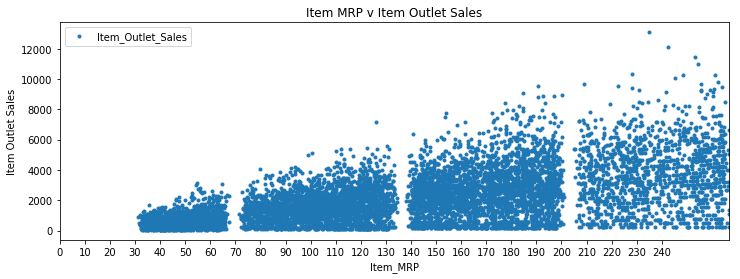

In [375]:
df.plot(x='Item_MRP', y='Item_Outlet_Sales', marker='.', linestyle='none', xticks=np.arange(0,250, 10), figsize=(12,4))
plt.ylabel('Item Outlet Sales')
plt.title('Item MRP v Item Outlet Sales')

#### Observations
- From looking at the two graphs we can tell that there's a slightly high correlation between **Item_Outlet_Sales** and **Item_MRP** which makes sense. This tells us that Item_MRP may be important when creating our model.
- The categories of values in Item_MRP are more prominent. There are clusters of values in the following ranges:<br>
    1. 30 - 68
    2. 72 - 135
    3. 140 - 200
    4. 205 - 267

In [376]:
df.apply(lambda col: col.nunique())

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

#### Observations
- 1559 Different Products
- 10 Stores
- 16 different types of items

In [377]:
# Filter categorical columns
categorical_columns = [x for x in df.dtypes.index if df.dtypes[x] == 'object']

# Exclude ID cols
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier', 'Outlet_Identifier']]

# Print frequency of categories
for col in categorical_columns:
    print(f'\nFrequency of Categories for {col}')
    print(df[col].value_counts())


Frequency of Categories for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Frequency of Categories for Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Frequency of Categories for Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for Outle

#### Observations
- Item_Fat_Content
    - There are in fact only 2 categories, Low Fat and Regular, but they show up with different spelling.
    - There is almost double the amount of Low Fat food compared to Regular food.
- Item_Type
    - Food in the 'Other' and 'Breakfast' categories can be bucketed into another category.
    - Seafood can be combined with meats to reduce the number of categories.
    - In general let's try to combine some of these buckets, especially the ones with a low count.
- Outlet_Size
    - There are comparatively few outlets marked as 'High' Outlet Size.
- Outlet_Type
    - Supermarket type1, type2, and type3 may be able to be combined into a general 'Supermarket' category.

# Data Cleaning and Feature Engineering

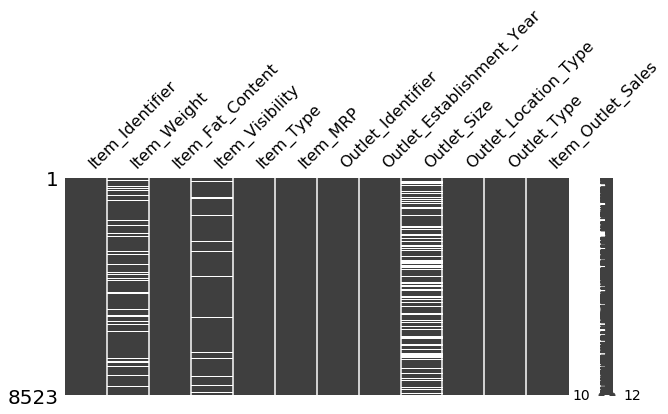

In [378]:
# Before we start let's correct the visibility 0 to be null instead
df.loc[df['Item_Visibility'] == 0.0, "Item_Visibility"] = np.NAN
mno.matrix(df, figsize=(10,4))

There are a null values in the Item_Weight, Item_Visibility, and Outlet_Size sections. It would be a good idea to impute these values using it's relationship with other columns to some extent. 
For Item_Weight the only 2 columns that may be able to help are Item_Type and Item_Fat_Content. There were some problems with Item_Fat_Content earlier, so we'll fix the values in this column before proceeding.

In [379]:
# Replacing all invalid values for Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                         'reg':'Regular',
                                                         'low fat':'Low Fat'})
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

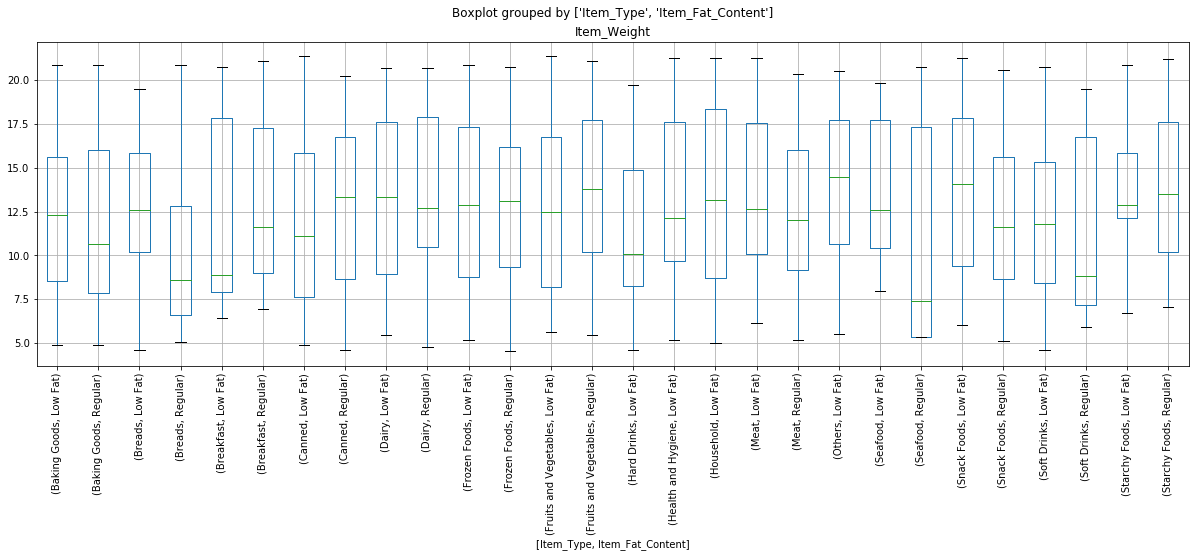

In [380]:
df.boxplot(column='Item_Weight', by=['Item_Type', 'Item_Fat_Content'], figsize=(20,6),rot=90)
plt.show()

By observing the boxplot we can tell that there is possibly a relationship between these variables. It's tempting to use the median to fill the Weight values.

In [381]:
median_vals = df.pivot_table(values='Item_Weight', index='Item_Fat_Content', columns = 'Item_Type', aggfunc = np.median)
median_vals

Item_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
Item_Fat_Content,,,,,,,,,,,,,,,,
Low Fat,12.30,12.6,8.895,11.10,13.35,12.85,12.5,10.1,12.15,13.15,12.65,14.5,12.60,14.1,11.80,12.85
Regular,10.65,8.6,11.600,13.35,12.70,13.10,13.8,NaN,NaN,NaN,12.00,NaN,7.42,11.6,8.85,13.50


There are some NaN values here, this is due to the fact that we noted earlier, there is too much variation in the Item_Types. So we can try to limit those and try again.
If we observe the Item Identifier, they all start with FD, NC, or DR, which stand for food, non-consumable, and drink, respectively. So we can make these the new values for Item_Type.

In [382]:
# Get the first 2 characters for every id and make it a new col
df['Broader_Item_ID'] = df['Item_Identifier'].apply(lambda x: x[:2])

# Rename the values for readability
df['Broader_Item_ID'] = df['Broader_Item_ID'].replace({'FD':'Food',
                                                       'NC':'Non-Consumable',
                                                       'DR':'Drink'                                         
                                                     })
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Broader_Item_ID
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable


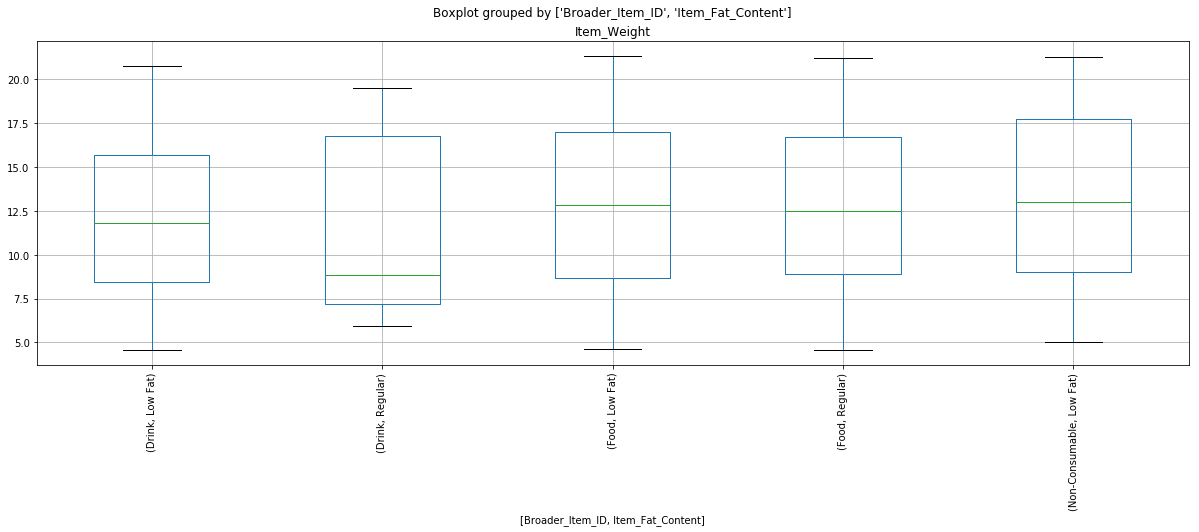

In [383]:
df.boxplot(column='Item_Weight', by=['Broader_Item_ID', 'Item_Fat_Content'], figsize=(20,6),rot=90)
plt.show()

We have Non-Consumable items marked as Low Fat when they should be in their own category

In [384]:
df.loc[df['Broader_Item_ID']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
df['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

In [385]:
median_vals = df.pivot_table(values='Item_Weight', index='Item_Fat_Content', columns = 'Broader_Item_ID', aggfunc = np.median)
median_vals

Broader_Item_ID,Drink,Food,Non-Consumable
Item_Fat_Content,,,
Low Fat,11.80,12.85,NaN
Non-Edible,NaN,NaN,13.0
Regular,8.85,12.50,NaN


In [386]:
df['Item_Weight'].fillna(df[df['Item_Weight'].isnull()].apply(lambda x: median_vals.loc[x['Item_Fat_Content'], x['Broader_Item_ID']], axis=1), inplace=True)

In [387]:
assert not df['Item_Weight'].isna().any()

#### Imputing Item Visibility

Since there doesn't exist a unique element with a visibility of 0, we can use the visibility of the the same item in a different store to fill the null values. 

In [388]:
visibility_avg = df.pivot_table(values='Item_Visibility', index='Item_Identifier')
df['Item_Visibility'].fillna(df[df['Item_Visibility'].isnull()].apply(lambda x: visibility_avg.loc[x['Item_Identifier']][0], axis=1), inplace=True)

In [389]:
assert not df['Item_Visibility'].isna().any()

In [390]:
df[df['Item_Identifier'] == 'FDA15']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Broader_Item_ID
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
831,FDA15,9.30,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208,Food
2599,FDA15,9.30,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Small,Tier 2,Supermarket Type1,6474.2392,Food
2643,FDA15,9.30,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Medium,Tier 3,Supermarket Type2,5976.2208,Food
4874,FDA15,9.30,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184,Food
5413,FDA15,9.30,Low Fat,0.016009,Dairy,250.6092,OUT013,1987,High,Tier 3,Supermarket Type1,6474.2392,Food
6696,FDA15,12.85,Low Fat,0.015945,Dairy,249.5092,OUT027,1985,Medium,Tier 3,Supermarket Type3,6474.2392,Food
7543,FDA15,9.30,Low Fat,0.016113,Dairy,248.8092,OUT017,2007,NaN,Tier 2,Supermarket Type1,5976.2208,Food


#### Imputing Outlet_Size

In [391]:
df.Outlet_Size.value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [392]:
df[df['Outlet_Size'].isna()].Outlet_Identifier.value_counts()

OUT045    929
OUT017    926
OUT010    555
Name: Outlet_Identifier, dtype: int64

Looks like all Outlets 045, 017, and 010 are missing their outlet size

In [393]:
df[df['Outlet_Size'].isna()].Outlet_Establishment_Year.value_counts()

2002    929
2007    926
1998    555
Name: Outlet_Establishment_Year, dtype: int64

It looks like 045 was the only outlet built in 2002, 017 was the only outlet built in 2007, and 010 was the only one built in 1998

In [394]:
df[df['Outlet_Size'].isna()].Outlet_Location_Type.value_counts()

Tier 2    1855
Tier 3     555
Name: Outlet_Location_Type, dtype: int64

In [395]:
df[df['Outlet_Size'].isna()].Outlet_Type.value_counts()

Supermarket Type1    1855
Grocery Store         555
Name: Outlet_Type, dtype: int64

045 and 017 are tier 2 supermarket , while 010 is a tier 3 grocery store

In [396]:
# looks like all grocery stores are small, so we can impute all grocery store value with small outlet size
df[df['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].value_counts()

Small    528
Name: Outlet_Size, dtype: int64

In [397]:
# This is not true for all supermarket type1
df[df['Outlet_Type'] == 'Supermarket Type1']['Outlet_Size'].value_counts()

Small     1860
High       932
Medium     930
Name: Outlet_Size, dtype: int64

In [398]:
df[df['Outlet_Type'] == 'Supermarket Type1'][['Outlet_Identifier', 'Outlet_Size']].drop_duplicates()

,Outlet_Identifier,Outlet_Size
0,OUT049,Medium
4,OUT013,High
8,OUT045,NaN
9,OUT017,NaN
11,OUT046,Small
19,OUT035,Small


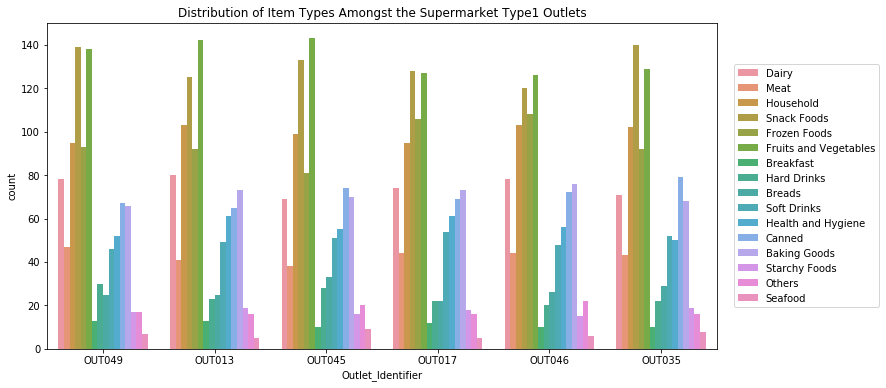

In [399]:
plt.figure(figsize=(12,6))
sns.countplot(x='Outlet_Identifier', data=df[(df['Outlet_Type'] == 'Supermarket Type1')], hue='Item_Type')
plt.legend(loc=5, bbox_to_anchor=(1.25,0.5))
plt.title('Distribution of Item Types Amongst the Supermarket Type1 Outlets')
plt.show()

This chart tells us the distribution of food for each of the supermarket type 1. There is a definite diffference between the distribution in small supermarkets (017, 046, 035) and the other supermarkets, especially in the snacks, frozen foods, and fruits and vegetables.<br>
Since 017 is missing and 046 and 035 are small It's a safe assumption that 017 is small as well.<br>

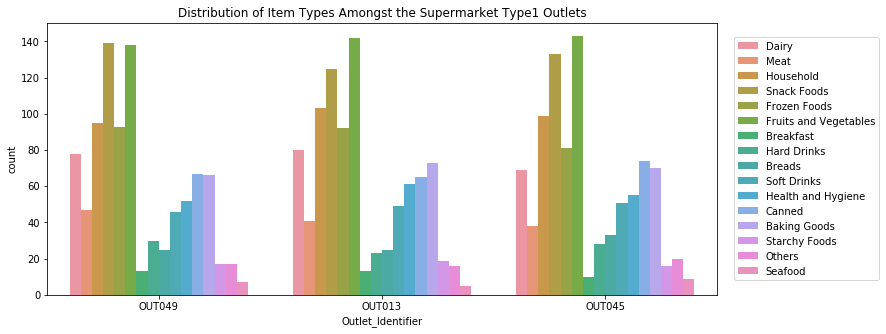

In [400]:
plt.figure(figsize=(12,5))
sns.countplot(x='Outlet_Identifier', 
              data=df[(df['Outlet_Type'] == 'Supermarket Type1')], 
              hue='Item_Type', 
              order=df[df['Outlet_Type'] == 'Supermarket Type1']['Outlet_Identifier'].drop_duplicates().iloc[:3])
plt.legend(loc=5, bbox_to_anchor=(1.25,0.5))
plt.title('Distribution of Item Types Amongst the Supermarket Type1 Outlets')
plt.show()

In [401]:
# Group by Outlet ID and Item type and compute the group size for each to get the number of each item per outlet
# Unstack to get it in a DF rather than a series
item_count = df[df['Outlet_Type'] == 'Supermarket Type1'].groupby(['Outlet_Identifier','Item_Type']).size().unstack()
item_count.loc[['OUT049', 'OUT013', 'OUT045']]

Item_Type,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
Outlet_Identifier,,,,,,,,,,,,,,,,
OUT049,66,25,13,67,78,93,138,30,52,95,47,17,7,139,46,17
OUT013,73,25,13,65,80,92,142,23,61,103,41,16,5,125,49,19
OUT045,70,33,10,74,69,81,143,28,55,99,38,20,9,133,51,16


In [402]:
print('Difference between 049 and 045: ' , (item_count.loc['OUT049'] - item_count.loc['OUT045']).sum())
print('Difference between 013 and 045: ', (item_count.loc['OUT013'] - item_count.loc['OUT045']).sum())

Difference between 049 and 045:  1
Difference between 013 and 045:  3


The difference in item distribution is very minimal, which is expected given the shape of the distribution we oberved above. 

In [403]:
# Testing to see if Larger stores have greater visibility of their products
df[df['Outlet_Type'] == 'Supermarket Type1'].groupby(['Outlet_Identifier'])['Item_Visibility'].mean()

Outlet_Identifier
OUT013    0.064737
OUT017    0.065582
OUT035    0.065340
OUT045    0.064987
OUT046    0.065951
OUT049    0.066152
Name: Item_Visibility, dtype: float64

Out of all of our testing and exploration. We can conclude that 010 and 017 are Small, while 045 is either medium or large. Since 049 and 045 are marginally more similar in item distribution, we're going to conclude that 045 is medium, although this is all speculation.

In [404]:
vals = pd.Series({'OUT010': 'Small', 'OUT017': 'Small', 'OUT045': 'Medium'})
df.Outlet_Size.fillna(df[df['Outlet_Size'].isna()].apply(lambda x: vals.loc[x['Outlet_Identifier']], axis=1), inplace=True)

In [405]:
assert not df['Outlet_Size'].isna().any()

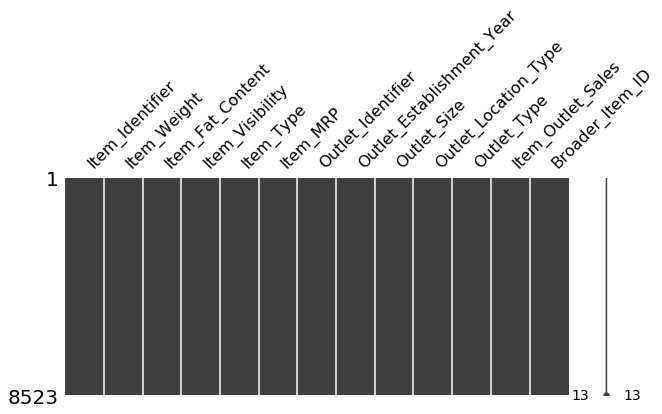

In [406]:
mno.matrix(df, figsize=(10,4))

#### Combining Outlet_Type

In [407]:
df.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


All 3 supermarkets have significantly different item_outlet_sales, so it's probably not a good idea to combine them into the general 'Supermarket' class

#### Determine years of operation of a store

In [408]:
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Broader_Item_ID,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.022911,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non-Edible,0.016164,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


The amount of time a store has been opened is more likely to be an indicator of Outlet Sales and will also be easier to normalize.

#### One-Hot Encoding of Variables

In [412]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Broader_Item_ID','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [413]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

At this point we've finally finished cleaning the data.